<a href="https://colab.research.google.com/github/nura6199/my-dissertation/blob/main/enginefaults6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# engine_fault_xgboost_pipeline_fully_balanced.py
# Full pipeline: Critical synthesis + upsampling + XGBoost + CV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample # Import resample from sklearn.utils
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load Dataset
# ======================
csv_path = "/content/drive/MyDrive/engine_fault_detection_dataset_balanced.csv"
target = "Engine_Condition"
df = pd.read_csv(csv_path)

X = df.drop(columns=[target])
y = df[target]

print("Original Class Distribution:\n", y.value_counts())


Original Class Distribution:
 Engine_Condition
0    5963
2    5963
1    5963
3    5963
Name: count, dtype: int64


In [8]:
# Scale Features
# ======================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
# ======================
# Step 1: Balance Normal, Warning, Minor with SMOTE
# ======================
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("After SMOTE:\n", pd.Series(y_res).value_counts())

After SMOTE:
 Engine_Condition
0    5963
2    5963
1    5963
3    5963
Name: count, dtype: int64


In [10]:
# Step 2: Generate Synthetic Critical Class
# ======================
warn_minor = X_res[(y_res == 1) | (y_res == 2)]
crit_mean = warn_minor.mean(axis=0)
crit_std  = warn_minor.std(axis=0)

n_samples = sum(y_res == 0)  # match Normal count initially
X_critical = np.random.normal(loc=crit_mean*1.5, scale=crit_std*1.2, size=(n_samples, X_res.shape[1]))
y_critical = np.full(n_samples, 3)

In [11]:
# Combine
X_final = np.vstack([X_res, X_critical])
y_final = np.concatenate([y_res, y_critical])
X_final_orig = scaler.inverse_transform(X_final)


In [12]:
# Build dataframe
df_balanced = pd.DataFrame(X_final_orig, columns=X.columns)
df_balanced[target] = y_final


In [13]:
# Step 3: Upsample ALL classes to 11,926 each
# ======================
df_normal   = df_balanced[df_balanced[target] == 0]
df_warning  = df_balanced[df_balanced[target] == 1]
df_minor    = df_balanced[df_balanced[target] == 2]
df_critical = df_balanced[df_balanced[target] == 3]

target_size = 11926

df_normal_up   = resample(df_normal,   replace=True, n_samples=target_size, random_state=42)
df_warning_up  = resample(df_warning,  replace=True, n_samples=target_size, random_state=42)
df_minor_up    = resample(df_minor,    replace=True, n_samples=target_size, random_state=42)
df_critical_up = resample(df_critical, replace=True, n_samples=target_size, random_state=42)

df_final = pd.concat([df_normal_up, df_warning_up, df_minor_up, df_critical_up])
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print("Final Class Distribution:\n", df_final[target].value_counts())

Final Class Distribution:
 Engine_Condition
1    11926
3    11926
2    11926
0    11926
Name: count, dtype: int64


In [14]:
# Save final balanced dataset
balanced_path = "/content/drive/MyDrive/datasets/engine_fault_detection_dataset_final_11926.csv"
df_final.to_csv(balanced_path, index=False)
print(f"\n✅ Fully balanced dataset saved at: {balanced_path}")


✅ Fully balanced dataset saved at: /content/drive/MyDrive/datasets/engine_fault_detection_dataset_final_11926.csv


In [15]:
# Model Training
# ======================
X_final = df_final.drop(columns=[target])
y_final = df_final[target]

scaler = StandardScaler()
X_scaled_final = scaler.fit_transform(X_final)

classes = np.unique(y_final)
weights = compute_class_weight("balanced", classes=classes, y=y_final)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_scaled_final, y_final)

print("\n=== Best Parameters ===")
print(grid.best_params_)
print("Best CV F1-macro:", grid.best_score_)

best_model = grid.best_estimator_

Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0), np.int64(3): np.float64(1.0)}
Fitting 5 folds for each of 32 candidates, totalling 160 fits

=== Best Parameters ===
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400, 'subsample': 0.8}
Best CV F1-macro: 0.9329515514853632


In [16]:
# Final Evaluation
# ======================
y_pred = cross_val_predict(best_model, X_scaled_final, y_final, cv=cv, method="predict")
y_proba = cross_val_predict(best_model, X_scaled_final, y_final, cv=cv, method="predict_proba")

print("\n=== Final CV Results (Best Model) ===")
print("Accuracy:", accuracy_score(y_final, y_pred))
print("Precision (macro):", precision_score(y_final, y_pred, average="macro"))
print("Recall (macro):", recall_score(y_final, y_pred, average="macro"))
print("F1 (macro):", f1_score(y_final, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_final, y_pred))


=== Final CV Results (Best Model) ===
Accuracy: 0.9328777461009559
Precision (macro): 0.9340278500131853
Recall (macro): 0.932877746100956
F1 (macro): 0.9329525747394336

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     11926
           1       0.90      0.94      0.92     11926
           2       0.95      0.98      0.97     11926
           3       0.98      0.90      0.94     11926

    accuracy                           0.93     47704
   macro avg       0.93      0.93      0.93     47704
weighted avg       0.93      0.93      0.93     47704



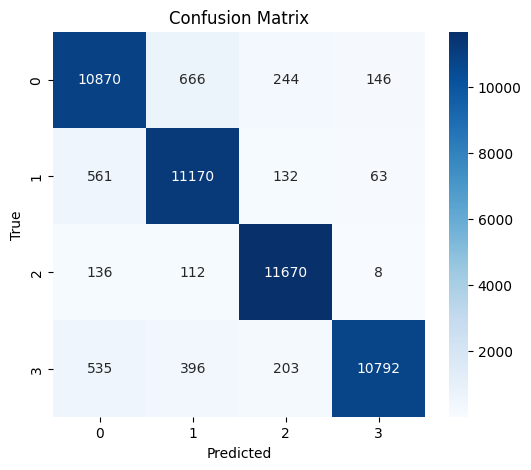

In [18]:
# ======================
# Confusion Matrix
# ======================
cm = confusion_matrix(y_final, y_pred, labels=classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


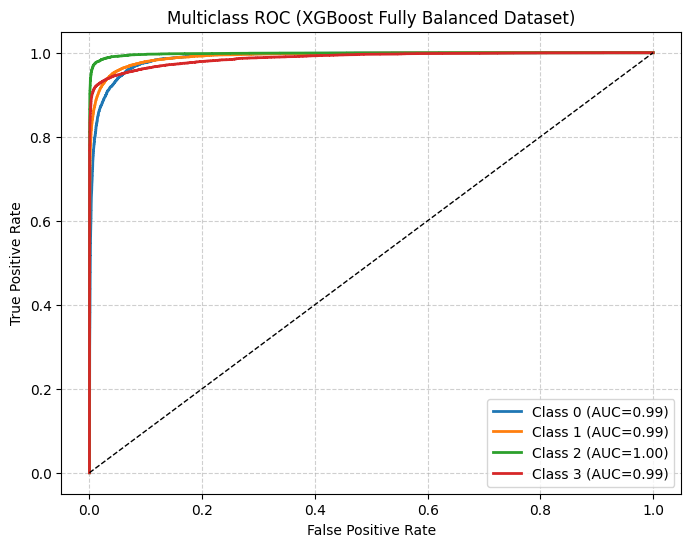

In [19]:
# ROC Curves (Multiclass)
# ======================
y_bin = label_binarize(y_final, classes=classes)
plt.figure(figsize=(8,6))

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC (XGBoost Fully Balanced Dataset)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [1]:
from sklearn.model_selection import train_test_split

# ======================
# Train-Test Split
# ======================
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled_final, y_final, test_size=0.2, stratify=y_final, random_state=42
)

# ======================
# XGBoost with eval_set
# ======================
best_xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    random_state=42,
    n_jobs=-1,
    **grid.best_params_   # use best params from GridSearch
)

# Train while monitoring training and validation loss
evals_result = {}
best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True,
    evals_result=evals_result,
    eval_metric="mlogloss"
)

# ======================
# Plot Training vs Validation Loss
# ======================
epochs = len(evals_result['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(8,6))
plt.plot(x_axis, evals_result['validation_0']['mlogloss'], label="Train Loss")
plt.plot(x_axis, evals_result['validation_1']['mlogloss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss (XGBoost)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

NameError: name 'X_scaled_final' is not defined

In [ ]:
# Model Training
# ======================
X_final = df_final.drop(columns=[target])
y_final = df_final[target]

scaler = StandardScaler()
X_scaled_final = scaler.fit_transform(X_final)

classes = np.unique(y_final)
weights = compute_class_weight("balanced", classes=classes, y=y_final)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_scaled_final, y_final)

print("\n=== Best Parameters ===")
print(grid.best_params_)
print("Best CV F1-macro:", grid.best_score_)

best_model = grid.best_estimator_